In [1]:
import os
import random

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import yfinance as yf

import pywt
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr

import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from statistics import mean

import requests
import datetime
import time
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler

plt.style.use('dark_background')

In [2]:
def get_dfs(freq_in_hours, days):
    url = 'https://api.binance.com/api/v3/klines'

    # List of cryptocurrency pairs (ETH and BTC only)
    cryptos = ['ETHUSDT', 'BTCUSDT']
    
    # Number of hours to fetch: 1754 days * 24 hours = 42,096 hours
    # Binance limit: 1000 candles (data points) per request, so we'll fetch 1000 hours at a time
    limit = 1000
    
    # Initialize an empty dictionary to store data for all cryptos
    crypto_data = {}
    for crypto in cryptos:
        # Initialize an empty list to store all the data for this crypto
        all_data = []
        total_hours = days * 24 / freq_in_hours
        # Get the current timestamp in milliseconds (Binance uses this format)
        end_time = int(time.time() * 1000)
        
        while total_hours > 0:
            # Fetch data in chunks of 1000 candles (hours)
            params = {
                'symbol': crypto,
                'interval': str(freq_in_hours) + 'h',  # 1-hour interval
                'limit': limit,  # Fetch 1000 data points at a time
                'endTime': end_time
            }
    
            # Fetch price data for the last chunk of 1000 hours
            response = requests.get(url, params=params)
            data = response.json()
    
            # Process data into a list of tuples (readable time, price)
            for price_point in data:
                timestamp = int(price_point[0]) / 1000  # Convert milliseconds to seconds
                readable_time = datetime.datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
                price = float(price_point[4])  # Close price
                all_data.append((readable_time, price))
    
            # Update the end_time to the timestamp of the earliest fetched data point
            end_time = int(data[0][0])  # The first data point is the oldest in this batch
    
            # Reduce the total hours by 1000 since we've fetched that many hours
            total_hours -= limit
    
            # Sleep for a short time to avoid hitting API rate limits
            time.sleep(1)
        # Store the processed data in a DataFrame
        crypto_data[crypto] = pd.DataFrame(all_data, columns=['Date', 'Price']).sort_values(by='Date')
    #print(crypto_data.tail())
    eth = crypto_data['ETHUSDT']
    eth = eth.reset_index(drop=True)
    #print(eth.tail())
    btc = crypto_data['BTCUSDT']
    btc = btc.reset_index(drop=True)
    #print(btc.tail())
    return eth, btc

In [3]:
eth_df, btc_df = get_dfs(freq_in_hours=1, days=1754)

In [4]:
def filter_indices(df, threshold=24):
    indices_to_keep = []
    b = True
    for ind in df.index:
        if not indices_to_keep:
            indices_to_keep.append(ind)
        else:
            b = True
            for itk in indices_to_keep:
                if abs(ind - itk) < threshold:
                    b = False
                    break
            if b:
                indices_to_keep.append(ind)
    return df.loc[indices_to_keep]

In [24]:
def find_pattern_with_scaled_composite_score_with_probs(data_frame, timestamps, future_timestamps, metric, plots_treshold, no_best_mathces, mse_ponder=150, mae_ponder=10, corr_ponder = 1, distance_ponder_w = 12.5, corr_ponder_w = 1):

    fs = 48  # 24 points per day
    sampling_period = 1 / fs  # Sampling period is 1 hour
    
    # Select a wavelet
    wavelet = 'morl'
    central_frequency = 0.849  # Typical value for Morlet
    
    # Define minimum and maximum scale based on your interests
    min_scale = central_frequency / (fs / 2 * sampling_period)  # Corresponds to the Nyquist frequency
    max_scale = central_frequency / (2 / fs * sampling_period)  # Corresponds to twice per day
    
    # Generate logarithmic scales
    num_scales = 30  # Number of scales
    scales = np.geomspace(min_scale, max_scale, num=num_scales)
    price = data_frame['Price'].values
    pattern = price[-timestamps:] - price[-timestamps] # starting from 0
    scaling_pattern = price[-timestamps]    # first value for scaling
    error_list = []  # List to store index, MSE, MAE, and Correlation
    gain_list = []
    real_gain = 0
    up_down_list = []
    for i in range(0, len(price) - 2*timestamps):
        possible_pattern = price[i:i + timestamps] - price[i]
        scaling_possible_pattern = price[i]
        scaled_possible_pattern = scaling_pattern / scaling_possible_pattern * possible_pattern

        # Ensure the data is in the correct shape for calculations
        pattern_flat = np.array(pattern).astype(float).flatten()
        scaled_possible_pattern_flat = np.array(scaled_possible_pattern).astype(float).flatten()

        # Calculate MSE and MAE
        mse_metric = mse(pattern_flat, scaled_possible_pattern_flat)
        mae_metric = mae(pattern_flat, scaled_possible_pattern_flat)
        
        # Calculate Pearson correlation coefficient
        try:
            correlation = np.corrcoef(pattern_flat, scaled_possible_pattern_flat)[0, 1]
        except Exception as e:
            print(f"Correlation error at index {i}: {e}, skipping.")
            continue
        # trying wavelet
        cwtmatr1, _ = pywt.cwt(pattern_flat, scales, 'morl')
        cwtmatr2, _ = pywt.cwt(scaled_possible_pattern_flat, scales, 'morl')
            
        distance_w = euclidean(cwtmatr1.flatten(), cwtmatr2.flatten())
        correlation_w = np.corrcoef(cwtmatr1.flatten(), cwtmatr2.flatten())[0, 1]
                 
        # Store index and metrics in the list
        index_and_errors = [i, mse_metric, mae_metric, correlation, distance_w, correlation_w]
        error_list.append(index_and_errors)

    # Convert to DataFrame
    
    error_df = pd.DataFrame(error_list, columns=['Index', 'MSE', 'MAE', 'Correlation','Distance Wavelet','Correlation Wavelet'])
    # Apply MinMaxScaler to everything
    
    scaler = MinMaxScaler()
    error_df[['MSE', 'MAE','Distance Wavelet']] = scaler.fit_transform(error_df[['MSE', 'MAE','Distance Wavelet']])
    
    error_df['1 - Correlation'] = 1 - error_df['Correlation']
    error_df['1 - Correlation'] = scaler.fit_transform(error_df[['1 - Correlation']])
    
    error_df['1 - Correlation Wavelet'] = 1 - error_df['Correlation Wavelet']
    error_df['1 - Correlation Wavelet'] = scaler.fit_transform(error_df[['1 - Correlation Wavelet']])
    
    error_df['Composite Score'] = mse_ponder*error_df['MSE'] + mae_ponder*error_df['MAE'] + corr_ponder* error_df['1 - Correlation'] + corr_ponder_w * error_df['1 - Correlation Wavelet'] + distance_ponder_w * error_df['Distance Wavelet']
    
    # Sort the DataFrame by the Composite Score
    error_df_sorted_repeating_indices = error_df.sort_values(by=metric, ascending=True)
    error_df_sorted = filter_indices(error_df_sorted_repeating_indices[:3*no_best_mathces],24)
    for j in range(0, len(error_df_sorted)-1):
        y_identified = price[-timestamps] + (price[error_df_sorted.index[j]: error_df_sorted.index[j] + timestamps + future_timestamps] -price[error_df_sorted.index[j]]) * price[-timestamps]/price[error_df_sorted.index[j]]
        y_real = price[-timestamps:]
        if j < plots_treshold:
            plt.figure(figsize=(8,4))
            plt.title(f'Moment of identified pattern: {data_frame.Date[error_df_sorted.index[j]]}, No. {j} best match')
            plt.plot(y_identified,label='y_identified')
            plt.plot(y_real,label='y_real')
            plt.axvline(x=timestamps-1, color='red', linestyle='--')
            plt.legend()
        gain = y_identified[-1] - y_identified[timestamps - 1]
        gain_list.append(gain)
    for i in range(0, len(gain_list)):
        if gain_list[i] > 0:
            up_down_list.append(1)
        else:
            up_down_list.append(0)
    return error_df_sorted,error_df_sorted_repeating_indices, gain_list, up_down_list

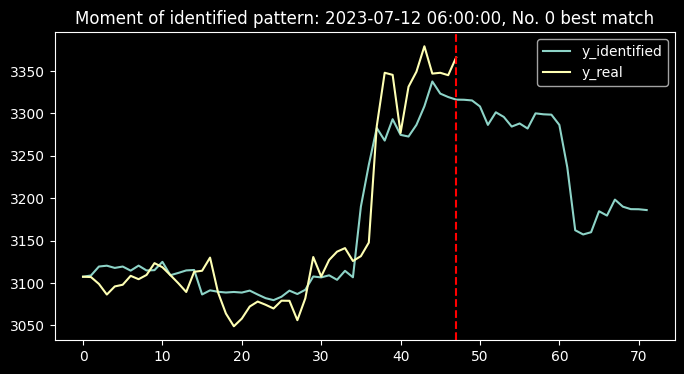

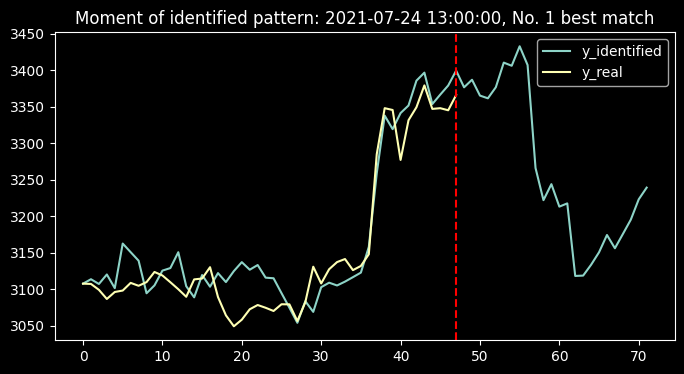

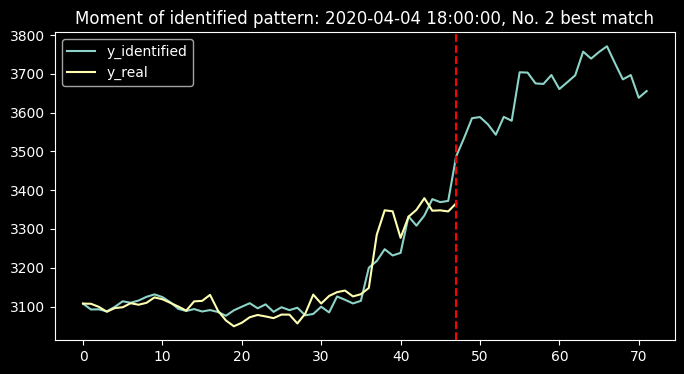

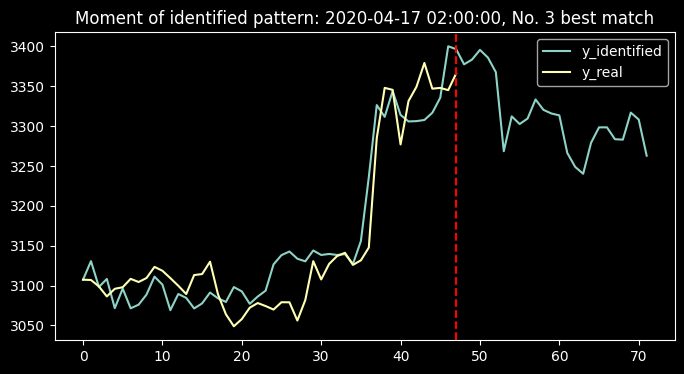

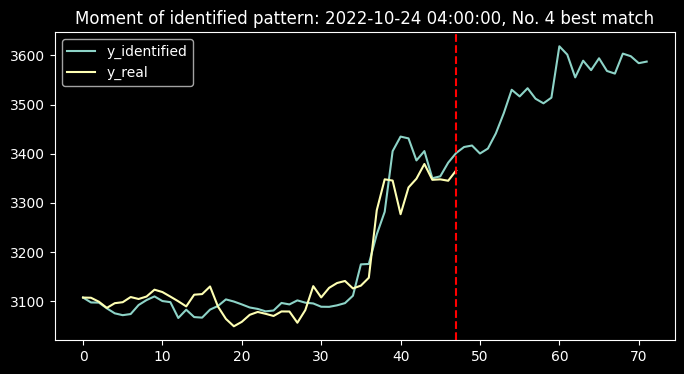

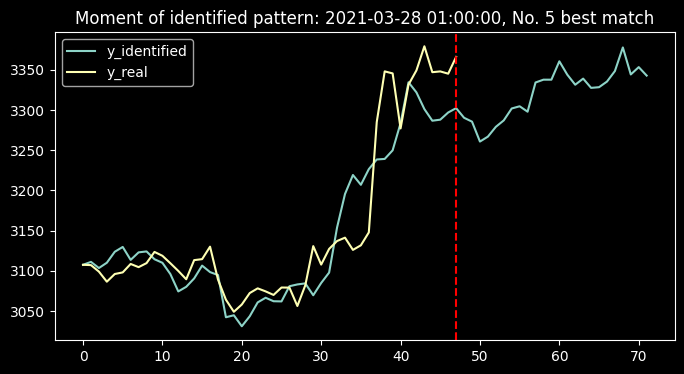

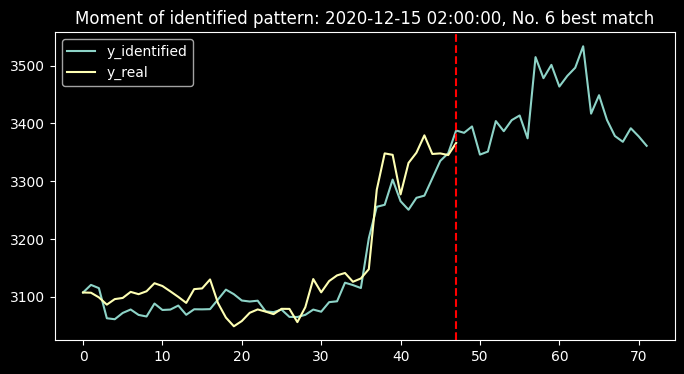

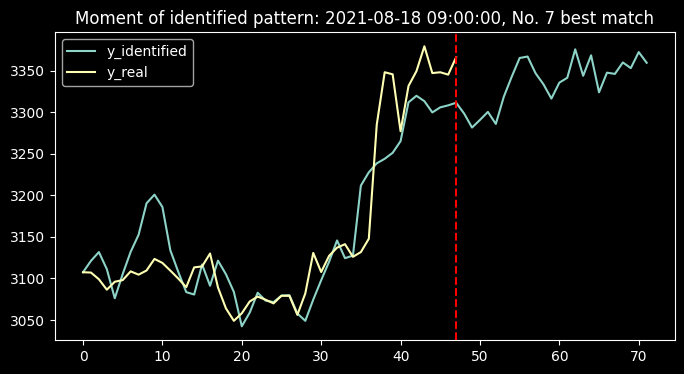

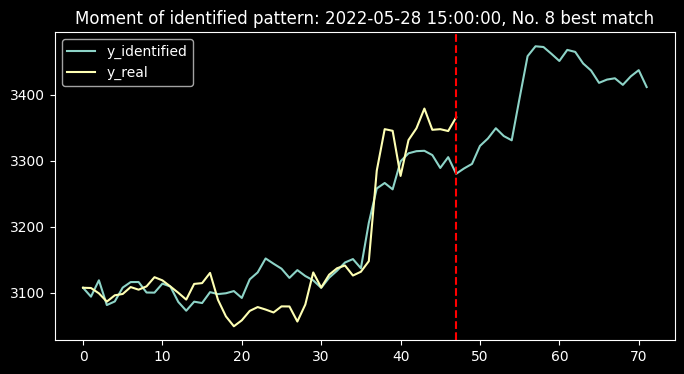

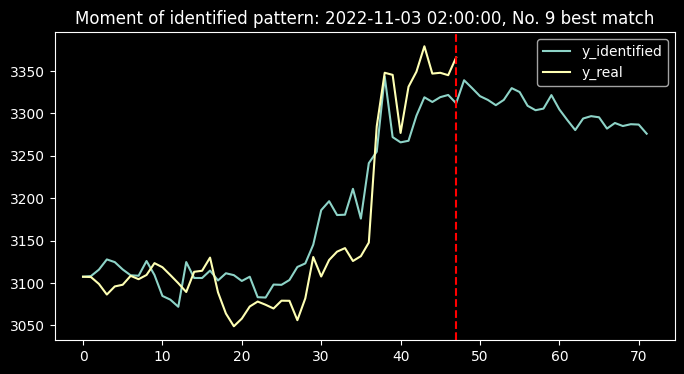

In [25]:
error_df_sorted, error_df_sorted_repeating_indices, gains, ups_downs = find_pattern_with_scaled_composite_score_with_probs(data_frame=eth_df,timestamps=48,future_timestamps=24,metric='Composite Score',plots_treshold=10, no_best_mathces=100)

In [57]:
mean(gains[:17])

49.964133869332784